# Лабораторная работа 1: Анализ и отбор признаков

**Цель работы:**
1. Найти и загрузить датасет с числовыми признаками с Hugging Face.
2. Очистить данные от выбросов.
3. Произвести отбор наиболее значимых признаков

## Шаг 1: Загрузка и подготовка датасета

Выбран датасет **Breast Cancer Wisconsin (Diagnostic) Data Set**. Он содержит 30 числовых признаков, описывающих характеристики клеточных ядер, и целевую переменную, указывающую на диагноз (злокачественная или доброкачественная опухоль).

In [41]:
# Установка необходимых библиотек
!pip install datasets pandas scikit-learn matplotlib seaborn -q


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Настройки для лучшего отображения графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [43]:
# Загрузка датасета с Hugging Face
dataset = load_dataset("scikit-learn/breast-cancer-wisconsin")

# Преобразование в pandas DataFrame для удобства
df = dataset["train"].to_pandas()

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### 1.1. Предварительная обработка данных


In [45]:
df = df.drop(['Unnamed: 32', 'id'], axis=1)
# Преобразуем 'diagnosis' в числовой формат: M (malignant) = 1, B (benign) = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Шаг 2: Очистка данных от выбросов

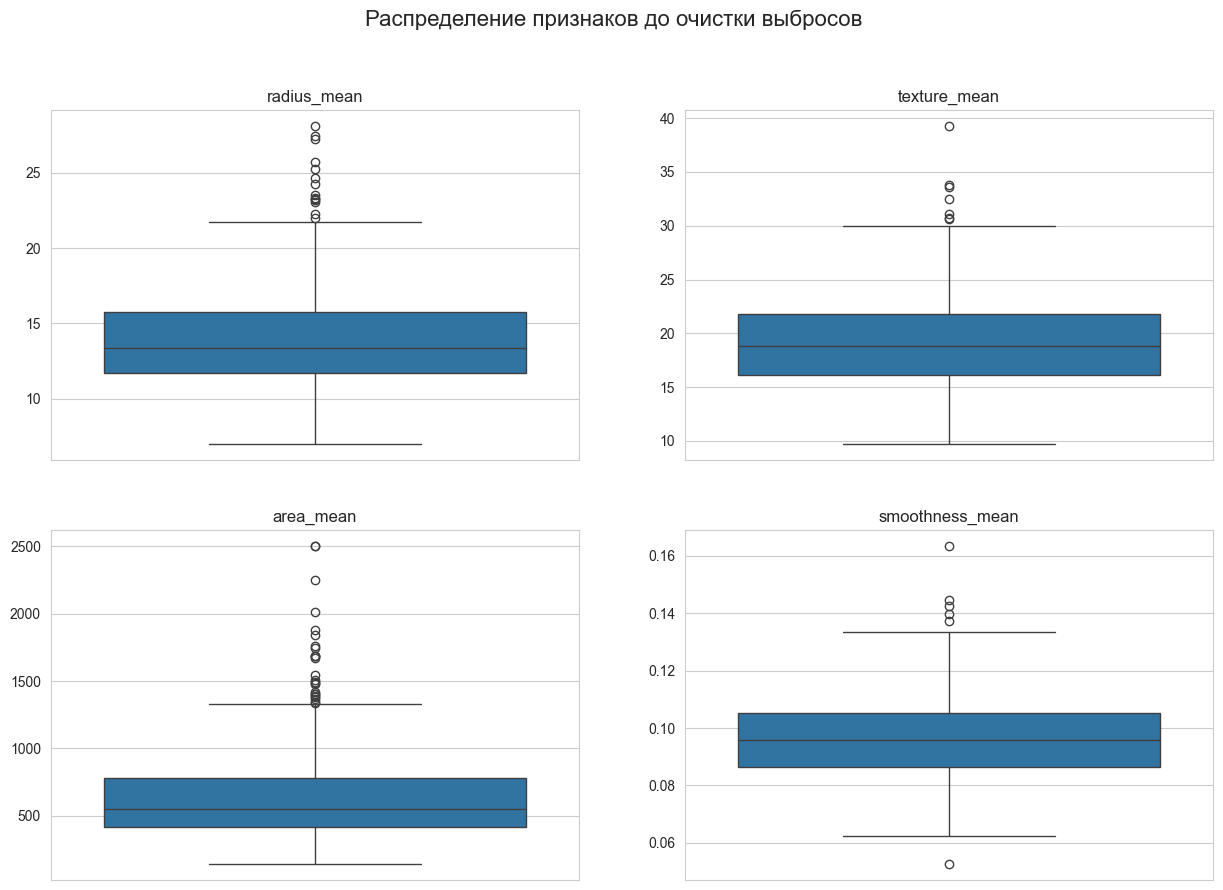

In [46]:
# Выбираем несколько признаков для анализа выбросов 
features_to_check = ['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Распределение признаков до очистки выбросов', fontsize=16)

for ax, feature in zip(axes.flatten(), features_to_check):
    sns.boxplot(y=df[feature], ax=ax) 
    ax.set_title(feature)
    ax.set_ylabel('')

plt.show()

In [47]:
df_cleaned = df.copy()

for col in df_cleaned.columns:
    # Применяем очистку ко всем числовым столбцам, кроме целевой переменной
    if df_cleaned[col].dtype in ['float64', 'int64'] and col != 'diagnosis':
        # Определение межквартильного размаха
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Кэппинг 
        df_cleaned.loc[df_cleaned[col] > upper_bound, col] = upper_bound
        df_cleaned.loc[df_cleaned[col] < lower_bound, col] = lower_bound


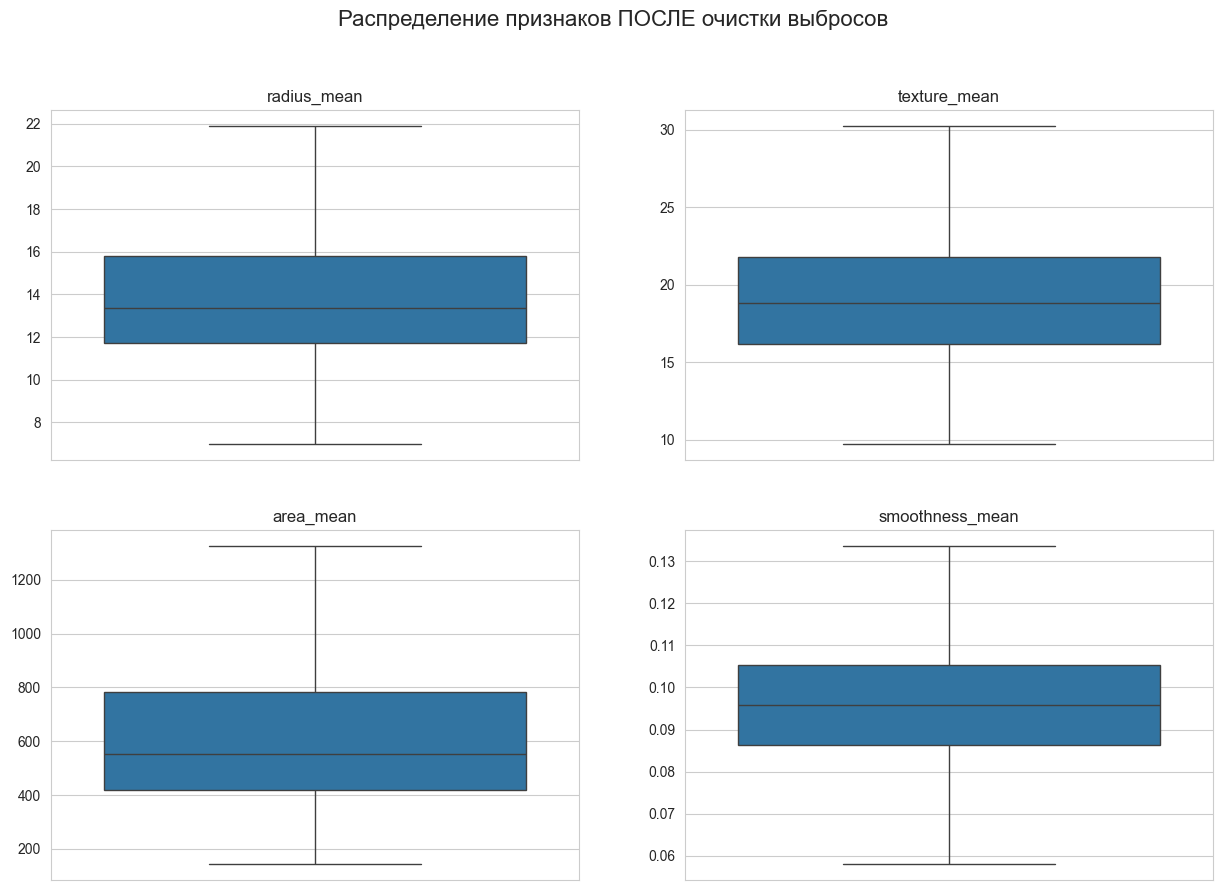

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Распределение признаков ПОСЛЕ очистки выбросов', fontsize=16)

for ax, feature in zip(axes.flatten(), features_to_check):
    sns.boxplot(y=df_cleaned[feature], ax=ax) 
    ax.set_title(feature)
    ax.set_ylabel('')

plt.show()

## Шаг 3: Отбор признаков с помощью RFE

In [49]:
# Подготовка данных для модели
X = df_cleaned.drop('diagnosis', axis=1)
y = df_cleaned['diagnosis']

# Инициализация модели, которая будет использоваться для оценки важности признаков
model = LogisticRegression(solver='liblinear', max_iter=1000)

# Инициализация RFE для выбора 10 лучших признаков
rfe = RFE(model, n_features_to_select=10)

# Обучение RFE
fit = rfe.fit(X, y)

In [50]:
# Создаем DataFrame с результатами для наглядности
feature_ranking = pd.DataFrame({
    'feature': X.columns,
    'ranking': fit.ranking_,
    'selected': fit.support_
}).sort_values(by='ranking')

print("Рейтинг и отбор признаков:")
display(feature_ranking)

Рейтинг и отбор признаков:


,feature,ranking,selected
0,radius_mean,1,True
7,concave points_mean,1,True
6,concavity_mean,1,True
10,radius_se,1,True
12,perimeter_se,1,True
26,concavity_worst,1,True
20,radius_worst,1,True
22,perimeter_worst,1,True
25,compactness_worst,1,True
27,concave points_worst,1,True


C:\Users\bubub\AppData\Local\Temp\ipykernel_20424\4174707522.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_ranking['ranking'], y=feature_ranking['feature'], palette='viridis')


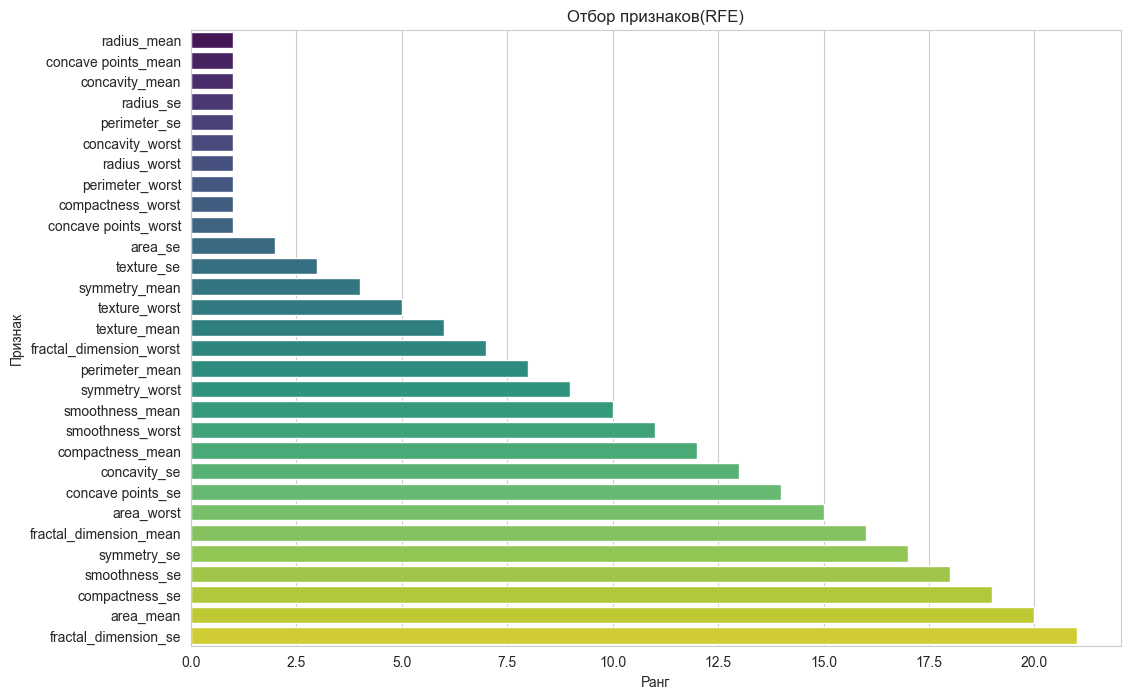

In [51]:
# Визуализация важности признаков
selected_features = feature_ranking[feature_ranking['selected'] == True]['feature'].values

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_ranking['ranking'], y=feature_ranking['feature'], palette='viridis')
plt.title('Отбор признаков(RFE)')
plt.xlabel('Ранг')
plt.ylabel('Признак')
plt.show()

